# Estudio de los datos tras las fases de procesado

Los datos han sido procesado a traves de otros archivos, este notebook es meramente explicativo y representativo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_parquet("..\\Archivos\\Business\\part-00000-be1f27a4-9044-46ac-a33d-4189b2080bdb-c000.snappy.parquet")

# Distribución de la variables

Como es obvio al ver las gráficas, las distribuciones son bastante erráticas. 

Esto se debe a que en un tránsito de red normal muchos valores se mantienen bajos, pero en cuanto un ataque use esa campo los valores se disparan.

Contra esto no podemos hacer mucho, ya que eliminar outliers nos dejaría a ciegas contra los ataques.

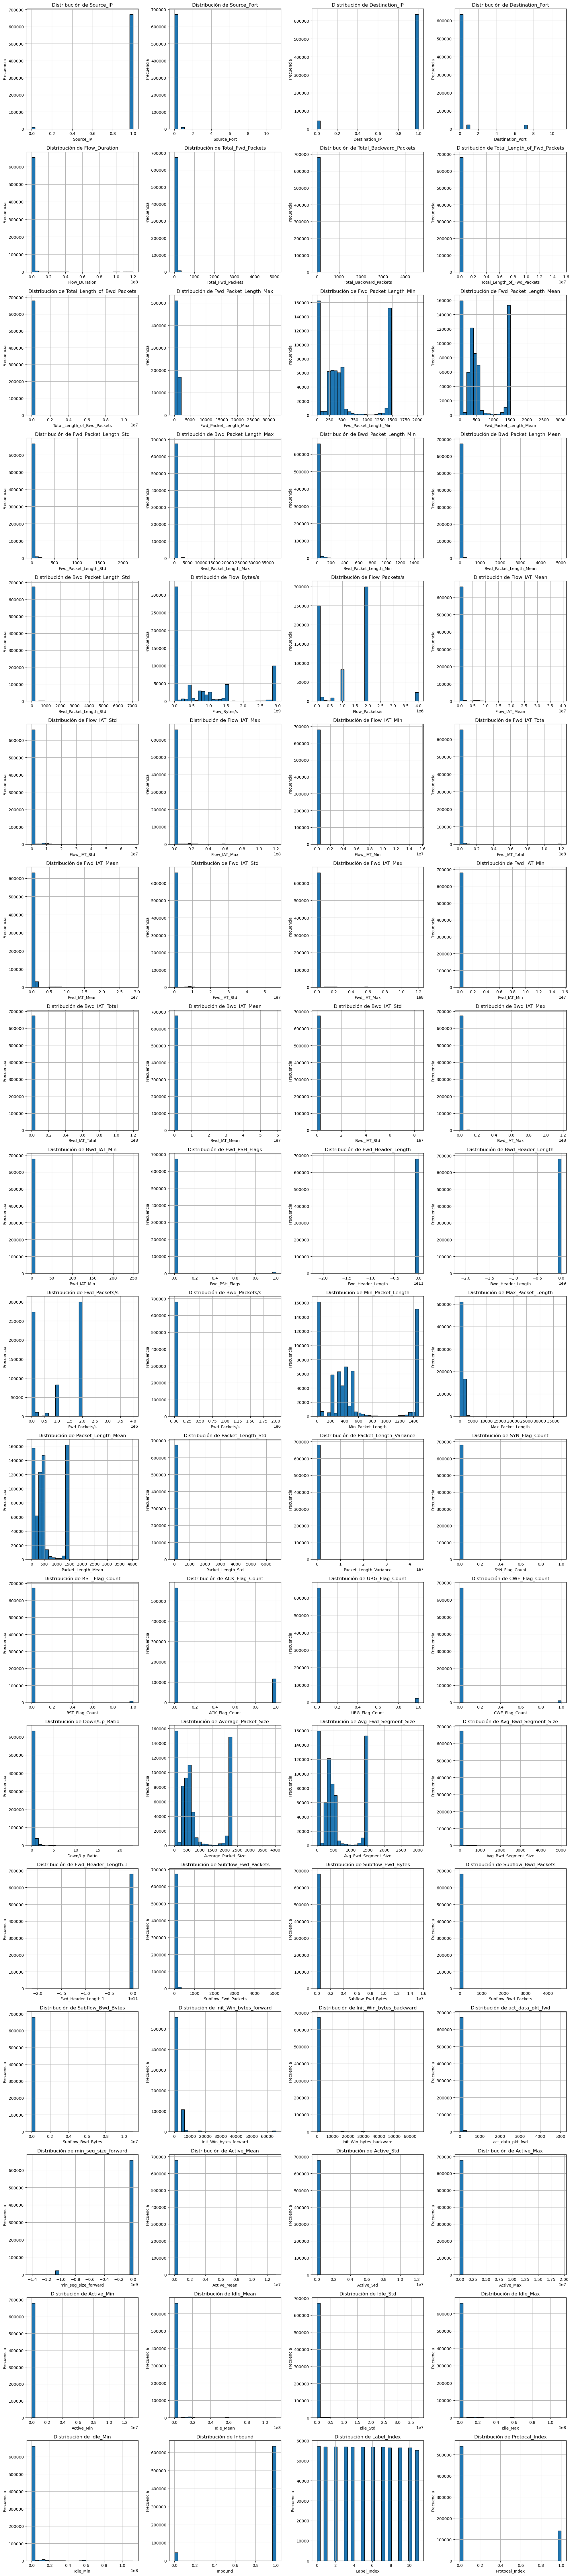

In [3]:
num_cols = 4
num_plots = len(df.columns)
num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    ax = axes[i]
    
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column].hist(bins=30, edgecolor='k', ax=ax)
        ax.set_title(f'Distribución de {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frecuencia')
    else:
        df[column].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(f'Distribución de {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frecuencia')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Correlaciones

In [4]:
corr = df.corr()

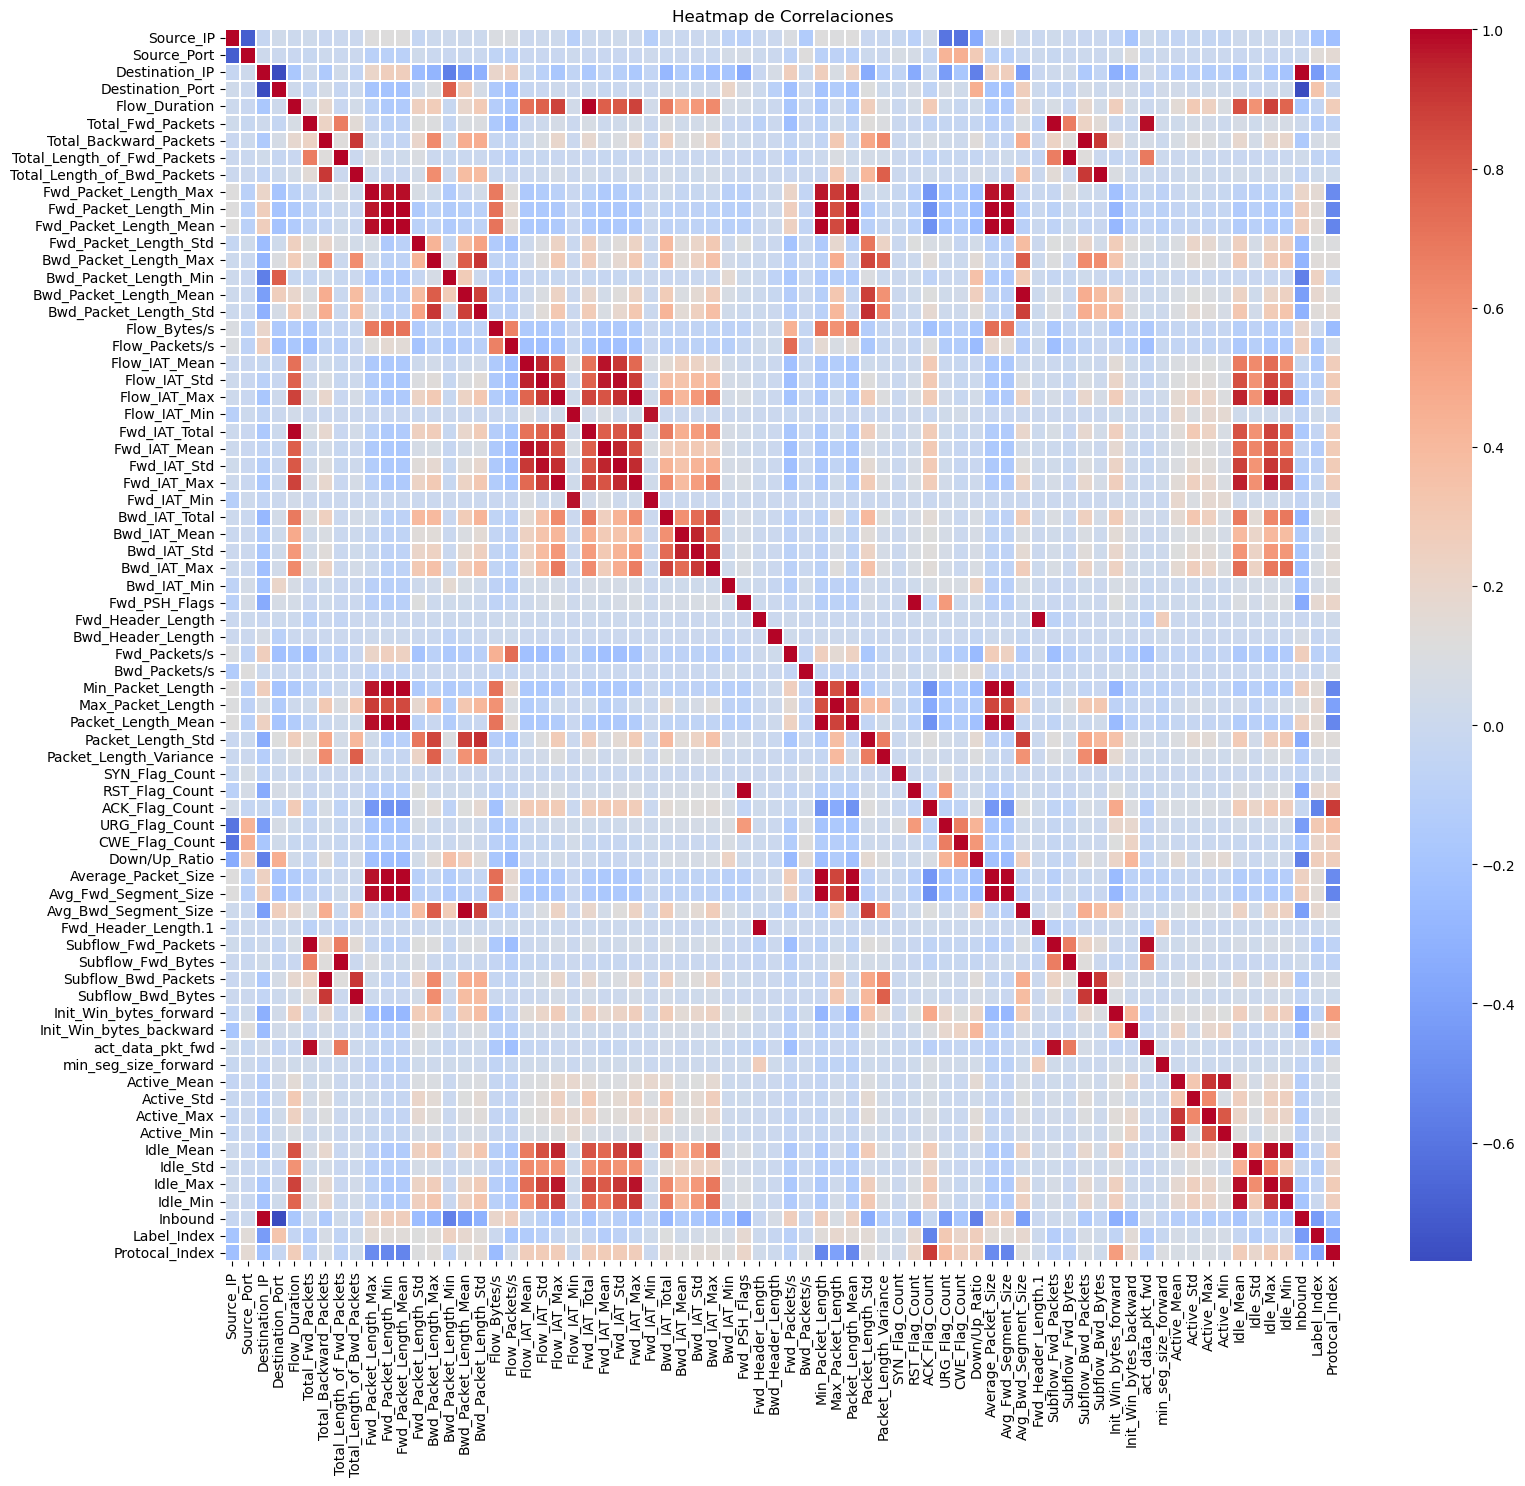

In [5]:
plt.figure(figsize=(18, 16))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.1)
plt.title('Heatmap de Correlaciones')
plt.show()

# Balanceo de datos

Hemos aplicado transformaciones previas para balancear las clases de ataques. Ahora tenemos un balanceo casi perfecto.

-  0 - DrDoS_NTP
-  1 - UDP-lag
-  2 - DrDoS_UDP
-  3 - BENIGN
-  4 - DrDos_MSSQL
-  5 - TFTP
-  6 - DrDoS_SSDP
-  7 - DrDoS_SNMP
-  8 - DrDos_NetBIOS
-  9 - DrDoS_DNS
- 10 - DrDoS_LDAP 
- 11 - Syn 

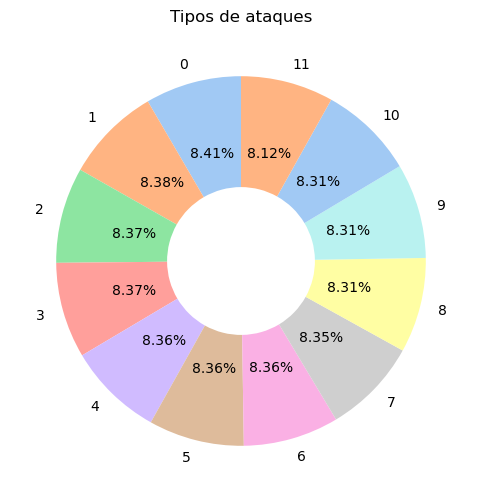

In [8]:
counts = df["Label_Index"].value_counts()

plt.figure(figsize=(6, 6))
counts.plot.pie(autopct='%1.2f%%', startangle=90, colors=sns.color_palette("pastel"), wedgeprops={'width': 0.6})

plt.title(f'Tipos de ataques')
plt.ylabel('')
plt.show()

# Transformaciones

Hemos aplicado un MinMaxScaler sobre las columnas numéricas, dejando los datos con valores entre 0 y 1.

Hemos elegido este pues no tenemos valores negativos ni tienen una distribución gaussiana. 

Además estan distribuidos con rangos de valores enormes.

In [9]:
from sklearn.preprocessing import MinMaxScaler

def apply_scaler(df, categorical_cols, scaler=None):

    if scaler is None:
        scaler = MinMaxScaler()

    cols = [col for col in df.columns if col not in categorical_cols]
    df[cols] = scaler.fit_transform(df[cols])

    return df

# Reducción de la dimensionalidad

Hemos realizado un estudio de la reducción de la dimesionalidad y valorado su implementación.

Hemos elegido el LDA por que necesitamos que tenga en cuenta las etiquetas de los tipos de ataque para reducir su tamaño.

Estos son los resultados obtenidos:

- 1: 0.8624436112787217
- 2: 0.9359429840282236
- 3: 0.9813085884081317
- 4: 0.9956001789574611
- 5: 0.9979355446343983
- 6: 0.9989342425775297
- 7: 0.9995660771324375
- 8: 0.9999569046056884
- 9: 0.9999981904383318
- 10: 0.9999999444649307
- 11: 1.0

Estos son muy buenos resultados. Escogimos reducirlo a 4 columnas por que es la que mejor relacion de valor/columna.

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def lda_variance_ratio(X, y):
    variance_ratio = {}

    n_features = X.shape[1]
    n_classes = len(set(y))
    max_components = min(n_features, n_classes - 1)

    for i in range(1, max_components + 1):
        lda = LDA(n_components=i)
        lda.fit(X, y)
        explained_variance = lda.explained_variance_ratio_
        variance_ratio[i] = explained_variance.sum()

    return variance_ratio

def apply_lda(df, target, n_components):
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    lda = LDA(n_components=n_components)
    lda.fit(X, y)
    X = lda.transform(X)
    X = pd.DataFrame(X)
    
    return pd.concat([X,y], axis=1)